In [68]:
import pandas as pd
import re 
from string import punctuation
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers.modeling_auto import AutoModel
from transformers import DistilBertTokenizer
import torch
%matplotlib inline

In [2]:
from google.colab import files

uploaded = files.upload()

In [ ]:
!unzip jigsaw-toxic-comment-train.csv.zip
!unzip validation.csv.zip

In [69]:
train = pd.read_csv('jigsaw-toxic-comment-train.csv')
val = pd.read_csv('validation.csv')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [9]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


In [10]:
val

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...,...
7995,7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1
7998,7998,El mapa del reinado de Alhaken esta ligerament...,es,0


# Описательный анализ тестовой выборки в сравнение с обучающей - (какие языки представлены, как они по статистикам отличаются от трейна) - 1.75 балла


In [11]:
val['lang'].unique()

array(['es', 'it', 'tr'], dtype=object)

In [12]:
stats = {}
stats["en"] = {"non-toxic": train[train['toxic'] == 0].shape[0], "toxic": train[train['toxic'] == 1].shape[0]}
for lang in val['lang'].unique():
  stats[lang] = {"non-toxic": val[(val['lang'] == lang) & (val['toxic'] == 0)].shape[0], "toxic": val[(val['lang'] == lang) & (val['toxic'] == 1)].shape[0]}

for lang in stats:
  toxic = stats[lang]["toxic"]
  non_toxic = stats[lang]["non-toxic"]
  print(f"lang: {lang}, toxic: {toxic}, non-toxic: {non_toxic}, ratio: {round((toxic+non_toxic)/toxic)}:{round((toxic+non_toxic)/non_toxic)}")

lang: en, toxic: 21384, non-toxic: 202165, ratio: 10:1
lang: es, toxic: 422, non-toxic: 2078, ratio: 6:1
lang: it, toxic: 488, non-toxic: 2012, ratio: 5:1
lang: tr, toxic: 320, non-toxic: 2680, ratio: 9:1


Как мы видим, в val представлены данные по трем языкам - испанскому, итальянскому и турецкому; в трейн выборке у нас есть лишь английский язык.  
Данных на английском языке ~100 раз больше, чем на других языках, при этом соотношения классов разнятся - для турецкого и английского соотношение классов ~ 10:1, для итальянского и испанского ~ 6:1

In [13]:
train['text_length'] = train['comment_text'].str.len()
val['text_length'] = val['comment_text'].str.len()

In [14]:
print("train, non-toxic: \n", train[train['toxic'] == 0]['text_length'].describe(), "\n")
print("train, toxic: \n", train[train['toxic'] == 1]['text_length'].describe(), "\n")
for lang in val['lang'].unique():
  print(f"{lang}, val, non-toxic: \n", val[(val['lang'] == lang) & (val['toxic'] == 0)]['text_length'].describe(), "\n")
  print(f"{lang}, val, toxic: \n", val[(val['lang'] == lang) & (val['toxic'] == 1)]['text_length'].describe(), "\n")

train, non-toxic: 
 count    202165.000000
mean        402.691178
std         589.421496
min           1.000000
25%         100.000000
50%         215.000000
75%         450.000000
max        5000.000000
Name: text_length, dtype: float64 

train, toxic: 
 count    21384.000000
mean       280.604097
std        613.588485
min          3.000000
25%         55.000000
50%        115.000000
75%        250.000000
max       5000.000000
Name: text_length, dtype: float64 

es, val, non-toxic: 
 count    2078.000000
mean      329.911453
std       229.772217
min        55.000000
25%       165.000000
50%       257.000000
75%       419.750000
max      1559.000000
Name: text_length, dtype: float64 

es, val, toxic: 
 count     422.000000
mean      285.921801
std       189.783552
min        48.000000
25%       152.000000
50%       223.000000
75%       361.500000
max      1089.000000
Name: text_length, dtype: float64 

it, val, non-toxic: 
 count    2012.000000
mean      347.234095
std       252.975916

Как мы можем заметить, для всех языков верно утверждение, что токсичный комментарий в среднем короче, чем нетоксичный; интересно, что std в английском у токсичных комментариев больше, для других языков верно обратное - с чем это связано, непонятно.  
При этом и минимальная длина комментария в английском языке меньше у нетоксичного комментария, хотя в других языках ситуация обратная.

# Поиск признаков, которые могут обобщаться на многоязычные данные (минимум 10 признаков рассмотрено,, обучать можно любую модель, оценивать нужно на validation.csv)  - 3 балла + поделился признаками своими...

In [70]:
# делаем минимум нормализации т.к. хотим учитывать как можно больше признаков
def soft_normalize(text):
  text = re.sub("\n|\t|\s\"", " ", text)
  return text

def tokenize(text):
  text = re.sub(f"[{punctuation}]", " ", text)
  text = re.sub("\s+", " ", text)
  return text.split()

def sentenize(text):
  sents = re.split("[\n.!?]( |$)", text)
  return [s for s in sents if len(s) > 0 and s != " "]

def sents_count(text):
  return len(sentenize(text))

def mean_token_length(text):
  length = 0
  tokens = tokenize(text)
  if len(tokens) == 0:
    return 0
  for token in tokens:
    length += len(token)
  return length/len(tokens)

def caps_ratio(text):
  total = len(text)
  caps = 0
  for letter in text:
    if letter not in punctuation and letter != " ":
      if letter.lower() != letter:
        caps += 1
  return caps/total

def nonalpha_ratio(text):
  total = len(text)
  nonalpha = 0
  sents = sentenize(text)
  for sent in sents:
    for letter in text:
      if letter in punctuation:
        nonalpha += 1
  return nonalpha/total

def numeric_ratio(text):
  total = len(text)
  numeric = 0
  for letter in text:
    if letter.isnumeric():
      numeric += 1
  return numeric/total

def has_link(text):
  return int(re.search("https?://[^ ]+", text) is not None)

def longest_word(text):
  tokens = tokenize(text)
  length = 0
  for t in tokens:
    if len(t) > length:
      length = len(t)
  return length

def max_sent_complexity(text):
  compl = 0
  sents = sentenize(text)
  for s in sents:
    matches = re.findall("[,;\:\-()]+", s)
    if len(matches) > compl:
      compl = len(matches)
  return compl

def rage_punctuation_length(text):
  length = 0
  matches = re.findall("[?!.]+", text)
  for m in matches:
    if len(m) > length:
      length = len(m)
  return length

def longest_same_char(text):
  length = 0
  curr_length = 1
  for i in range(1,len(text)):
    if text[i] == text[i-1]:
      curr_length += 1
    else:
      if curr_length > length:
        length = curr_length
      curr_length = 1
  if curr_length > length:
    return curr_length
  return length 

In [71]:
train['text_soft_normalized'] = train['comment_text'].apply(soft_normalize)

train['text_mean_tokens_length'] = train['text_soft_normalized'].apply(mean_token_length)
train['text_sents_count'] = train['comment_text'].apply(sents_count)
train['text_caps_ratio'] = train['comment_text'].apply(caps_ratio)
train['text_nonalpha_ratio'] = train['text_soft_normalized'].apply(nonalpha_ratio)
train['text_numeric_ratio'] = train['comment_text'].apply(numeric_ratio)
train['text_has_link'] = train['comment_text'].apply(has_link)
train['text_longest_word'] = train['text_soft_normalized'].apply(longest_word)
train['text_complexity'] = train['text_soft_normalized'].apply(max_sent_complexity)
train['text_rage_punctuation_length'] = train['text_soft_normalized'].apply(rage_punctuation_length)
train['text_longest_same_char'] = train['text_soft_normalized'].apply(longest_same_char)

In [72]:
val['text_soft_normalized'] = val['comment_text'].apply(soft_normalize)

val['text_mean_tokens_length'] = val['text_soft_normalized'].apply(mean_token_length)
val['text_sents_count'] = val['comment_text'].apply(sents_count)
val['text_caps_ratio'] = val['comment_text'].apply(caps_ratio)
val['text_nonalpha_ratio'] = val['text_soft_normalized'].apply(nonalpha_ratio)
val['text_numeric_ratio'] = val['comment_text'].apply(numeric_ratio)
val['text_has_link'] = val['comment_text'].apply(has_link)
val['text_longest_word'] = val['text_soft_normalized'].apply(longest_word)
val['text_complexity'] = val['text_soft_normalized'].apply(max_sent_complexity)
val['text_rage_punctuation_length'] = val['text_soft_normalized'].apply(rage_punctuation_length)
val['text_longest_same_char'] = val['text_soft_normalized'].apply(longest_same_char)

In [73]:
X_train = train[['text_mean_tokens_length', 'text_sents_count', 'text_caps_ratio', 'text_nonalpha_ratio', 'text_numeric_ratio', 'text_has_link', 'text_longest_word', 'text_complexity', 'text_rage_punctuation_length', 'text_longest_same_char']].values
Y_train = train['toxic']
X_val = val[['text_mean_tokens_length', 'text_sents_count', 'text_caps_ratio', 'text_nonalpha_ratio', 'text_numeric_ratio', 'text_has_link', 'text_longest_word', 'text_complexity', 'text_rage_punctuation_length', 'text_longest_same_char']].values
Y_val = val['toxic']

In [76]:
splits = 10

kf = KFold(n_splits=splits, random_state=42, shuffle=True)
score_train = []
score_train_sum = 0
for train, test in kf.split(X_train):
  X_train_train, X_train_test, Y_train_train, Y_train_test = X_train[train], X_train[test], Y_train[train], Y_train[test]
  clf = DecisionTreeClassifier(class_weight = {0: 0.91, 1:0.09}, random_state=42).fit(X_train_train, Y_train_train)
  predicted = clf.predict_proba(X_train_test)
  score = roc_auc_score(Y_train_test, predicted[:,1])
  score_train_sum += score
  score_train.append(score)

mean_score_train = score_train_sum/splits
std = 0
for score in score_train:
  std += (score - mean_score_train) * (score - mean_score_train)
  
print(std/splits)

clf = DecisionTreeClassifier(class_weight = {0: 0.91, 1:0.09}, random_state=42).fit(X_train, Y_train)
predicted = clf.predict_proba(X_val)
score_val = roc_auc_score(Y_val, predicted[:,1])

print(mean_score_train)
print(score_val)

1.5913664753103432e-05
0.5859285719491146
0.5426875502876151


Как видим, std очень маленькое, так что переобучения нет; roc_auc_score на val не особо хуже, чем на отложенных трейнах, радуемся этому!
Похоже, что какие-то из признаков действительно рабочие

# Бейзлайн модель, которая работает на отложенной выборке (из трейна) и validation.csv (различие в точности может быть большим, но главное попробовать любыми способами его уменьшить и зафиксировать эксперименты) - 3 балла

Будем использовать те же признаки, что и выше, однако попробуем разные модели

In [77]:
splits = 10
kf = KFold(n_splits=splits, random_state=42, shuffle=True)

def baseline(model):
  score_train = []
  score_train_sum = 0
  for train, test in kf.split(X_train):
    X_train_train, X_train_test, Y_train_train, Y_train_test = X_train[train], X_train[test], Y_train[train], Y_train[test]
    clf = model.fit(X_train_train, Y_train_train)
    predicted = clf.predict_proba(X_train_test)
    score = roc_auc_score(Y_train_test,  predicted[:,1])
    score_train_sum += score
    score_train.append(score)

  mean_score_train = score_train_sum/splits
  std = 0
  for score in score_train:
    std += (score - mean_score_train) * (score - mean_score_train)

  clf = model.fit(X_train, Y_train)
  predicted = clf.predict_proba(X_val)
  score_val = roc_auc_score(Y_val,  predicted[:,1])

  print(f"train_score: {mean_score_train}, val_score: {score_val}")

In [78]:
models = [
          DecisionTreeClassifier(class_weight = {0: 0.91, 1:0.09}, random_state=42),
          RandomForestClassifier(class_weight = {0: 0.91, 1:0.09}, random_state=42, n_estimators=50),
          ExtraTreesClassifier(class_weight = {0: 0.91, 1:0.09}, random_state=42, n_estimators=50),
          MultinomialNB(class_prior=[0.91,0.09]),
          GaussianNB(priors=[0.91,0.09]),
          LogisticRegression(class_weight={0: 0.91, 1:0.09}, max_iter=300),
          KNeighborsClassifier(),
]

for model in models:
  baseline(model)

train_score: 0.5859285719491146, val_score: 0.5426875502876151
train_score: 0.7312826772661561, val_score: 0.6485904456533487
train_score: 0.7135508171095305, val_score: 0.6387966398866352
train_score: 0.6867655263336436, val_score: 0.6057530232613995
train_score: 0.6605248197860274, val_score: 0.5829539095243242
train_score: 0.7050580943294105, val_score: 0.621663364196419
train_score: 0.6443288156403926, val_score: 0.5619443743920453


"Классические" модели не поднимаются выше 0.65, что насчет нейронок?

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=20, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [17]:
inputs = tf.keras.layers.Input(shape=(10,))
dense = tf.keras.layers.Dense(10, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=True,
            callbacks=[early_stop])

Epoch 1/1000
219/219 [==============================] - 1s 6ms/step - loss: 0.4949 - auc: 0.5848 - val_loss: 0.5005 - val_auc: 0.5583
Epoch 2/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.3368 - auc: 0.6705 - val_loss: 0.4895 - val_auc: 0.6188
Epoch 3/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.3136 - auc: 0.7042 - val_loss: 0.4683 - val_auc: 0.6468
Epoch 4/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.2996 - auc: 0.7156 - val_loss: 0.4576 - val_auc: 0.6632
Epoch 5/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.2960 - auc: 0.7224 - val_loss: 0.4607 - val_auc: 0.6728
Epoch 6/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.2896 - auc: 0.7291 - val_loss: 0.4583 - val_auc: 0.6711
Epoch 7/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.2903 - auc: 0.7312 - val_loss: 0.4623 - val_auc: 0.6709
Epoch 8/1000
219/219 [==============================] - 1s 5ms

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


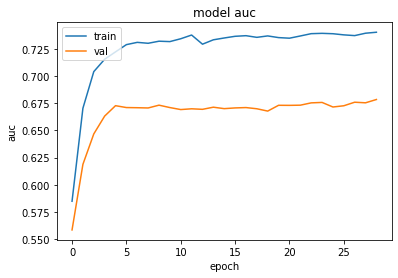

In [18]:
print(simple_keras_model.history.history.keys())
# summarize history for auc
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Немного лучше, будем пытаться ее тьюнить

Epoch 00037: early stopping


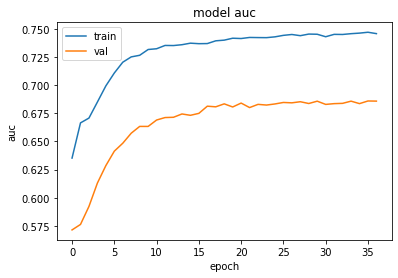

In [49]:
inputs = tf.keras.layers.Input(shape=(10,))
dense = tf.keras.layers.Dense(10, activation='relu')(inputs)
drop = tf.keras.layers.Dropout(0.1)(dense)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=False,
            callbacks=[early_stop])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 00036: early stopping


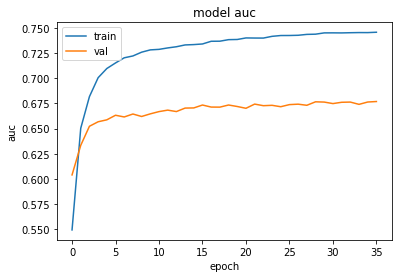

Epoch 00042: early stopping


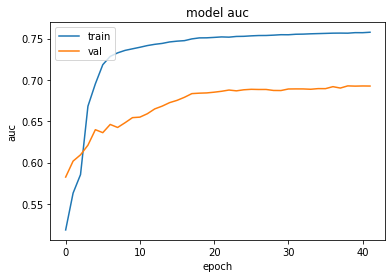

Epoch 00073: early stopping


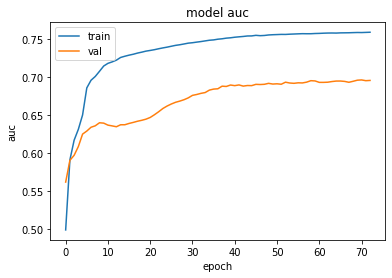

Epoch 00028: early stopping


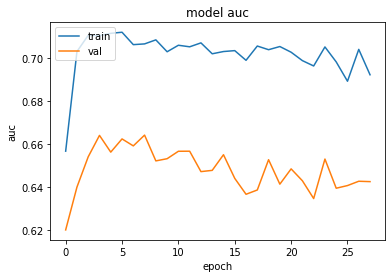

In [62]:
for a in ['relu',
          'softmax',
          'sigmoid',
          'linear']:
  inputs = tf.keras.layers.Input(shape=(10,))
  dense = tf.keras.layers.Dense(10, activation=a)(inputs)
  drop = tf.keras.layers.Dropout(0.1)(dense)

  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
  simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  simple_keras_model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[keras.metrics.AUC(name='auc')])
  simple_keras_model.fit(X_train, Y_train, 
              validation_data=(X_val, Y_val),
              batch_size=1024,
              epochs=1000,
              verbose=False,
              callbacks=[early_stop])
  plt.plot(simple_keras_model.history.history['auc'])
  plt.plot(simple_keras_model.history.history['val_auc'])
  plt.title('model auc')
  plt.ylabel('auc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Epoch 00072: early stopping


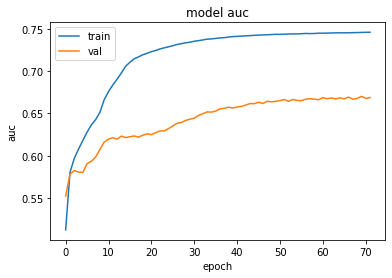

Epoch 00083: early stopping


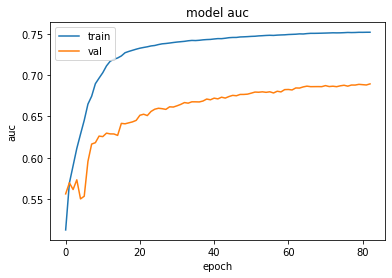

Epoch 00055: early stopping


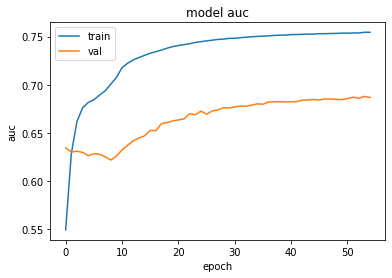

Epoch 00054: early stopping


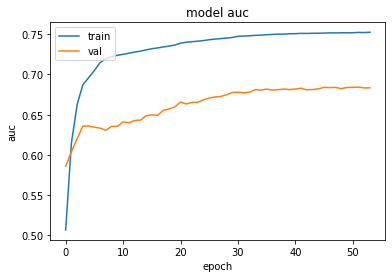

Epoch 00052: early stopping


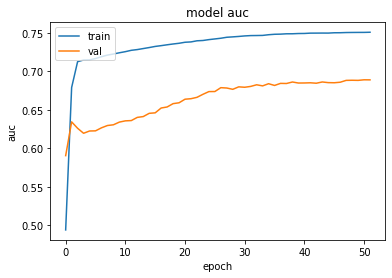

Epoch 00056: early stopping


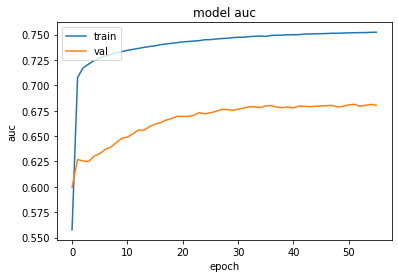

Epoch 00048: early stopping


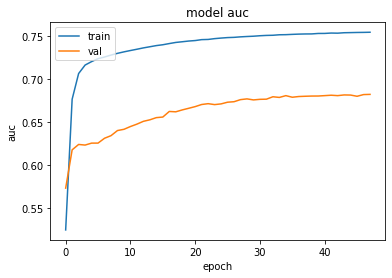

Epoch 00043: early stopping


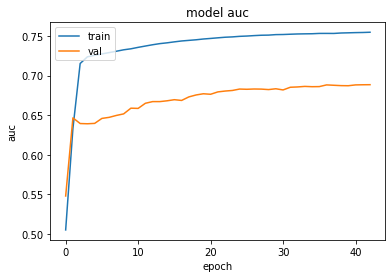

Epoch 00066: early stopping


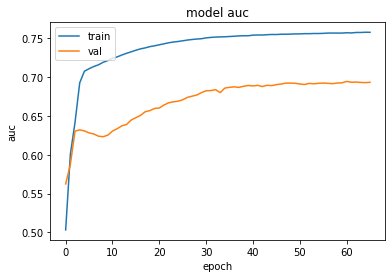

In [63]:
for c in [2,3,4,5,6,7,8,9,10]:
  inputs = tf.keras.layers.Input(shape=(10,))
  dense = tf.keras.layers.Dense(c, activation='sigmoid')(inputs)
  drop = tf.keras.layers.Dropout(0.1)(dense)

  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
  simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  simple_keras_model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[keras.metrics.AUC(name='auc')])
  simple_keras_model.fit(X_train, Y_train, 
              validation_data=(X_val, Y_val),
              batch_size=1024,
              epochs=1000,
              verbose=False,
              callbacks=[early_stop])
  plt.plot(simple_keras_model.history.history['auc'])
  plt.plot(simple_keras_model.history.history['val_auc'])
  plt.title('model auc')
  plt.ylabel('auc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

Epoch 00021: early stopping


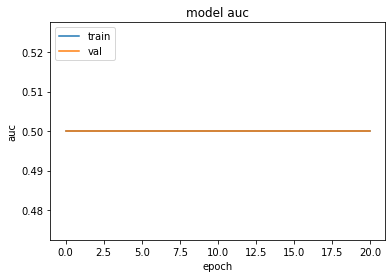

Epoch 00048: early stopping


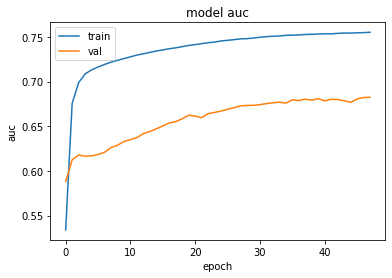

In [66]:
for a in ['softmax',
          'sigmoid']:
  inputs = tf.keras.layers.Input(shape=(10,))
  dense = tf.keras.layers.Dense(10, activation='sigmoid')(inputs)
  drop = tf.keras.layers.Dropout(0.1)(dense)

  outputs = tf.keras.layers.Dense(1, activation=a)(dense)
  simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  simple_keras_model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=[keras.metrics.AUC(name='auc')])
  simple_keras_model.fit(X_train, Y_train, 
              validation_data=(X_val, Y_val),
              batch_size=1024,
              epochs=1000,
              verbose=False,
              callbacks=[early_stop])
  plt.plot(simple_keras_model.history.history['auc'])
  plt.plot(simple_keras_model.history.history['val_auc'])
  plt.title('model auc')
  plt.ylabel('auc')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [43]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('simple_keras_model.weights', # названия файла 
                                                monitor='val_auc', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

Epoch 1/1000
217/219 [============================>.] - ETA: 0s - loss: 0.3438 - auc: 0.5400
Epoch 00001: val_auc improved from -inf to 0.55984, saving model to simple_keras_model.weights
219/219 [==============================] - 1s 6ms/step - loss: 0.3436 - auc: 0.5405 - val_loss: 0.4492 - val_auc: 0.5598
Epoch 2/1000
212/219 [============================>.] - ETA: 0s - loss: 0.3039 - auc: 0.6489
Epoch 00002: val_auc improved from 0.55984 to 0.60862, saving model to simple_keras_model.weights
219/219 [==============================] - 1s 5ms/step - loss: 0.3041 - auc: 0.6505 - val_loss: 0.4411 - val_auc: 0.6086
Epoch 3/1000
218/219 [============================>.] - ETA: 0s - loss: 0.2980 - auc: 0.6901
Epoch 00003: val_auc improved from 0.60862 to 0.62112, saving model to simple_keras_model.weights
219/219 [==============================] - 1s 4ms/step - loss: 0.2979 - auc: 0.6901 - val_loss: 0.4410 - val_auc: 0.6211
Epoch 4/1000
208/219 [===========================>..] - ETA: 0s - l

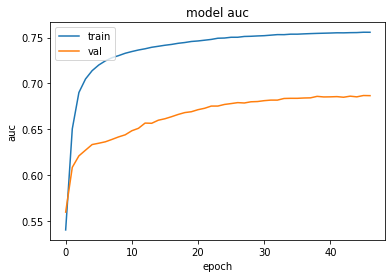

In [15]:
inputs = tf.keras.layers.Input(shape=(10,))
dense = tf.keras.layers.Dense(10, activation='sigmoid')(inputs)
drop = tf.keras.layers.Dropout(0.1)(dense)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=True,
            callbacks=[early_stop, checkpoint])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Получили 0.68683 на val

Видимо, нам все же придется использовать слова при обучении..
Хотим получить мультиязыковые эмбеддинги, возьмем для этого LASER, развернем у себя (https://towardsdatascience.com/multilingual-sentence-models-in-nlp-476f1f246d2f) и будем ходить в него

In [18]:
def get_vect(query_in, lang = 'en'):
    url = "http://95.27.245.212:8050/vectorize"
    params = {"q": query_in, "lang": lang}
    resp = requests.get(url=url, params=params).json()
    return np.array(resp["embedding"])

def get_vect_en(query_in):
  return get_vect(query_in, lang = 'en')

def get_vect_es(query_in):
  return get_vect(query_in, lang = 'es')

def get_vect_it(query_in):
  return get_vect(query_in, lang = 'it')

def get_vect_tr(query_in):
  return get_vect(query_in, lang = 'tr')

Затестим:

In [89]:
input_dict = {
    "tr":"Köpekleri severim. Onlar sevimli.",
    "ru":"Я люблю собак. Они очень красивые.",
}
embedded_dict = {}
for key in input_dict:
    embedded_dict[key] = get_vect(input_dict[key], lang = key)
from sklearn.metrics.pairwise import cosine_similarity
cos_lib = cosine_similarity(embedded_dict['tr'], embedded_dict['ru'])
cos_lib

array([[0.92918434]])

In [44]:
def hard_normalize(text):
  text = re.sub("[^\w.!?]", " ", text.lower())
  text = re.sub("\d+", " ", text.lower())
  return re.sub("\s+", " ", text)

Порежем размеры данных :С

In [45]:
train_cutted_toxic = train[train['toxic'] == 1]
train_cutted_toxic = train_cutted_toxic[:int(len(train_cutted_toxic)*0.01)]

train_cutted_non_toxic = train[train['toxic'] == 0]
train_cutted_non_toxic = train_cutted_non_toxic[:int(len(train_cutted_non_toxic)*0.01)]

train_cutted = pd.concat([train_cutted_toxic, train_cutted_non_toxic])
train_cutted['text_hard_normalized'] = train_cutted['comment_text'].apply(hard_normalize)
train_cutted['text_emb'] = train_cutted['text_hard_normalized'].apply(get_vect_en)

In [46]:
val_cutted_toxic_es = val[(val['toxic'] == 1) & (val['lang']=='es')]
val_cutted_toxic_es = val_cutted_toxic_es[:int(len(val_cutted_toxic_es)*0.1)]
val_cutted_non_toxic_es = val[(val['toxic'] == 0) & (val['lang']=='es')]
val_cutted_non_toxic_es = val_cutted_non_toxic_es[:int(len(val_cutted_non_toxic_es)*0.1)]
val_cutted_es = pd.concat([val_cutted_toxic_es, val_cutted_non_toxic_es])
val_cutted_es['text_hard_normalized'] = val_cutted_es['comment_text'].apply(hard_normalize)
val_cutted_es['text_emb'] = val_cutted_es['text_hard_normalized'].apply(get_vect_es)


val_cutted_toxic_it = val[(val['toxic'] == 1) & (val['lang']=='it')]
val_cutted_toxic_it = val_cutted_toxic_it[:int(len(val_cutted_toxic_it)*0.1)]
val_cutted_non_toxic_it = val[(val['toxic'] == 0) & (val['lang']=='it')]
val_cutted_non_toxic_it = val_cutted_non_toxic_it[:int(len(val_cutted_non_toxic_it)*0.1)]
val_cutted_it = pd.concat([val_cutted_toxic_it, val_cutted_non_toxic_it])
val_cutted_it['text_hard_normalized'] = val_cutted_it['comment_text'].apply(hard_normalize)
val_cutted_it['text_emb'] = val_cutted_it['text_hard_normalized'].apply(get_vect_it)


val_cutted_toxic_tr = val[(val['toxic'] == 1) & (val['lang']=='tr')]
val_cutted_toxic_tr = val_cutted_toxic_tr[:int(len(val_cutted_toxic_tr)*0.1)]
val_cutted_non_toxic_tr = val[(val['toxic'] == 0) & (val['lang']=='tr')]
val_cutted_non_toxic_tr = val_cutted_non_toxic_tr[:int(len(val_cutted_non_toxic_tr)*0.1)]
val_cutted_tr = pd.concat([val_cutted_toxic_tr, val_cutted_non_toxic_tr])
val_cutted_tr['text_hard_normalized'] = val_cutted_tr['comment_text'].apply(hard_normalize)
val_cutted_tr['text_emb'] = val_cutted_tr['text_hard_normalized'].apply(get_vect_tr)

val_cutted = pd.concat([val_cutted_es, val_cutted_it, val_cutted_tr])

In [94]:
print(train_cutted.iloc[0]['text_emb'].shape)
print(val_cutted.iloc[0]['text_emb'].shape)

(1, 1024)
(1, 1024)


In [47]:
X_train = train_cutted[['text_mean_tokens_length', 'text_sents_count', 'text_caps_ratio', 'text_nonalpha_ratio', 'text_numeric_ratio', 'text_has_link', 'text_longest_word', 'text_complexity', 'text_rage_punctuation_length', 'text_longest_same_char']].values
Y_train = train_cutted['toxic']
X_val = val_cutted[['text_mean_tokens_length', 'text_sents_count', 'text_caps_ratio', 'text_nonalpha_ratio', 'text_numeric_ratio', 'text_has_link', 'text_longest_word', 'text_complexity', 'text_rage_punctuation_length', 'text_longest_same_char']].values
Y_val = val_cutted['toxic']
X_train_emb = train_cutted['text_emb'].values
X_val_emb = val_cutted['text_emb'].values

In [283]:
print(X_train[0].shape)
print(X_val_emb[0].shape)
print(X_train_emb[0].shape)
print(X_val[0].shape)

(10,)
(1, 1024)
(1, 1024)
(10,)


In [284]:
X_train_emb = []
for _, row in train_cutted.iterrows():
  val = row['text_emb']
  X_train_emb.append(val.reshape(1024))
X_train_emb = np.array(X_train_emb)

X_val_emb = []
for _, row in val_cutted.iterrows():
  val = row['text_emb']
  X_val_emb.append(val.reshape(1024))
X_val_emb = np.array(X_val_emb)

In [285]:
print(X_train[0], X_train[0].shape, type(X_train[0]), X_train.shape, type(X_train))
print(X_val[0], X_val[0].shape, type(X_val[0]), X_val.shape, type(X_val))
print(X_train_emb[0], X_train_emb[0].shape, type(X_train_emb[0]), X_train_emb.shape, type(X_train_emb))
print(X_val_emb[0], X_val_emb[0].shape, type(X_val_emb[0]), X_val_emb.shape, type(X_val_emb))

[ 4.625       1.          0.84090909  0.          0.          0.
 10.          0.          0.          2.        ] (10,) <class 'numpy.ndarray'> (2234, 10) <class 'numpy.ndarray'>
[ 4.75        4.          0.03012048  0.14457831  0.01204819  0.
 10.          2.          1.          1.        ] (10,) <class 'numpy.ndarray'> (798, 10) <class 'numpy.ndarray'>
[ 5.74728101e-03  3.30164767e-05  4.73328587e-03 ... -1.45058997e-03
  2.31614839e-02  1.36543624e-02] (1024,) <class 'numpy.ndarray'> (2234, 1024) <class 'numpy.ndarray'>
[ 0.01698663  0.00306405 -0.00117845 ...  0.0068103   0.01594133
  0.03619507] (1024,) <class 'numpy.ndarray'> (798, 1024) <class 'numpy.ndarray'>


In [ ]:
inputs = tf.keras.layers.Input(shape=(10,))
dense = tf.keras.layers.Dense(10, activation='sigmoid')(inputs)
drop = tf.keras.layers.Dropout(0.1)(dense)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
simple_keras_model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=False,
            callbacks=[early_stop, checkpoint])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Auc на val не так сильно упал (до 0.6425), радуемся. 
Теперь попробуем учитывать полученные нами эмбеддинги


Epoch 00001: val_auc improved from -inf to 0.57028, saving model to simple_keras_model.weights

Epoch 00002: val_auc improved from 0.57028 to 0.58273, saving model to simple_keras_model.weights

Epoch 00003: val_auc improved from 0.58273 to 0.59811, saving model to simple_keras_model.weights

Epoch 00004: val_auc improved from 0.59811 to 0.61597, saving model to simple_keras_model.weights

Epoch 00005: val_auc improved from 0.61597 to 0.63349, saving model to simple_keras_model.weights

Epoch 00006: val_auc improved from 0.63349 to 0.64444, saving model to simple_keras_model.weights

Epoch 00007: val_auc improved from 0.64444 to 0.65815, saving model to simple_keras_model.weights

Epoch 00008: val_auc improved from 0.65815 to 0.66917, saving model to simple_keras_model.weights

Epoch 00009: val_auc improved from 0.66917 to 0.67972, saving model to simple_keras_model.weights

Epoch 00010: val_auc improved from 0.67972 to 0.68923, saving model to simple_keras_model.weights

Epoch 00011:

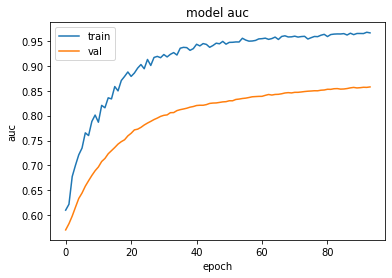

In [338]:
inputs_params = tf.keras.layers.Input(shape=(10,), name="input_params")
dense_params = tf.keras.layers.Dense(10, activation='sigmoid', name="dense_params")(inputs_params)
drop_params = tf.keras.layers.Dropout(0.1, name="drop_params")(dense_params)

inputs_embs = tf.keras.layers.Input(shape=(1024,), name="input_emb")
drop_emb = tf.keras.layers.Dropout(0.1, name="drop_emb")(inputs_embs)

conc = tf.keras.layers.concatenate([drop_params, drop_emb], name="concat")

dense = tf.keras.layers.Dense(1, name="dense")(conc)
outputs = tf.keras.layers.Activation('relu', name="activation")(dense)
simple_keras_model = tf.keras.Model(inputs=[inputs_params, inputs_embs], outputs=outputs, name="simple_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit([X_train,X_train_emb], Y_train, 
            validation_data=([X_val,X_val_emb], Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=False,
            callbacks=[early_stop, checkpoint])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Epoch 00001: val_auc did not improve from 0.85772

Epoch 00002: val_auc did not improve from 0.85772

Epoch 00003: val_auc did not improve from 0.85772

Epoch 00004: val_auc did not improve from 0.85772

Epoch 00005: val_auc did not improve from 0.85772

Epoch 00006: val_auc did not improve from 0.85772

Epoch 00007: val_auc did not improve from 0.85772

Epoch 00008: val_auc did not improve from 0.85772

Epoch 00009: val_auc did not improve from 0.85772

Epoch 00010: val_auc did not improve from 0.85772

Epoch 00011: val_auc did not improve from 0.85772

Epoch 00012: val_auc did not improve from 0.85772

Epoch 00013: val_auc did not improve from 0.85772

Epoch 00014: val_auc did not improve from 0.85772

Epoch 00015: val_auc did not improve from 0.85772

Epoch 00016: val_auc did not improve from 0.85772

Epoch 00017: val_auc did not improve from 0.85772

Epoch 00018: val_auc did not improve from 0.85772

Epoch 00019: val_auc did not improve from 0.85772

Epoch 00020: val_auc did not i

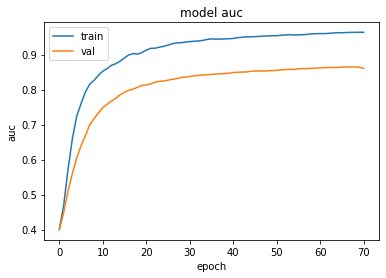

In [342]:
inputs_params = tf.keras.layers.Input(shape=(10,), name="input_params")
dense_params = tf.keras.layers.Dense(10, activation='sigmoid', name="dense_params")(inputs_params)

inputs_embs = tf.keras.layers.Input(shape=(1024,), name="input_emb")

conc = tf.keras.layers.concatenate([dense_params, inputs_embs], name="concat")

dense = tf.keras.layers.Dense(1, name="dense")(conc)
outputs = tf.keras.layers.Activation('relu', name="activation")(dense)
simple_keras_model = tf.keras.Model(inputs=[inputs_params, inputs_embs], outputs=outputs, name="simple_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit([X_train,X_train_emb], Y_train, 
            validation_data=([X_val,X_val_emb], Y_val),
            batch_size=1024,
            epochs=1000,
            verbose=False,
            callbacks=[early_stop, checkpoint])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Epoch 00001: val_auc did not improve from 0.88067

Epoch 00002: val_auc did not improve from 0.88067

Epoch 00003: val_auc did not improve from 0.88067

Epoch 00004: val_auc did not improve from 0.88067

Epoch 00005: val_auc did not improve from 0.88067

Epoch 00006: val_auc did not improve from 0.88067

Epoch 00007: val_auc did not improve from 0.88067

Epoch 00008: val_auc did not improve from 0.88067

Epoch 00009: val_auc did not improve from 0.88067

Epoch 00010: val_auc did not improve from 0.88067

Epoch 00011: val_auc did not improve from 0.88067

Epoch 00012: val_auc did not improve from 0.88067

Epoch 00013: val_auc did not improve from 0.88067

Epoch 00014: val_auc did not improve from 0.88067

Epoch 00015: val_auc did not improve from 0.88067

Epoch 00016: val_auc did not improve from 0.88067

Epoch 00017: val_auc did not improve from 0.88067

Epoch 00018: val_auc did not improve from 0.88067

Epoch 00019: val_auc did not improve from 0.88067

Epoch 00020: val_auc did not i

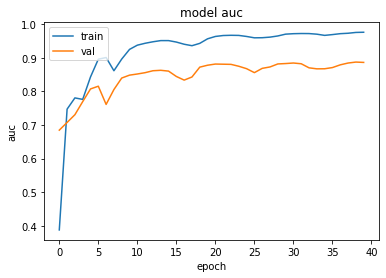

In [380]:
inputs_params = tf.keras.layers.Input(shape=(10,), name="input_params")
dense_params = tf.keras.layers.Dense(10, activation='sigmoid', name="dense_params")(inputs_params)

inputs_embs = tf.keras.layers.Input(shape=(1024,), name="input_emb")
dense_embs = tf.keras.layers.Dense(500, activation="relu", name="dense_embs")(inputs_embs)

conc = tf.keras.layers.concatenate([dense_params, dense_embs], name="concat")

dense = tf.keras.layers.Dense(1, name="dense")(conc)
outputs = tf.keras.layers.Activation('relu', name="activation")(dense)
simple_keras_model = tf.keras.Model(inputs=[inputs_params, inputs_embs], outputs=outputs, name="simple_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])
simple_keras_model.fit([X_train,X_train_emb], Y_train, 
            validation_data=([X_val,X_val_emb], Y_val),
            batch_size=3000,
            epochs=200,
            verbose=False,
            callbacks=[early_stop, checkpoint])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Лучший результат - 0.88762 на val

# Использование предобучнной модели из huggingface для обучения классификатора с оценкой на validation.csv - 3 балла

In [48]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_bert = AutoModel.from_pretrained('distilbert-base-multilingual-cased').to(torch.device('cuda'))

In [49]:
def get_bert_tokens(texts):
  texts_ids = [torch.tensor(tokenizer.encode(t, add_special_tokens=True, max_length=300, pad_to_max_length=True)) for t in texts]
  texts_ids = torch.nn.utils.rnn.pad_sequence(texts_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  return texts_ids

In [50]:
train_texts = [row['text_hard_normalized'] for _, row in train_cutted.iterrows()]
val_texts = [row['text_hard_normalized'] for _, row in val_cutted.iterrows()]

In [51]:
train_embs_bert = np.zeros((len(train_texts), 768))
batch = []
inds = []
for i, text in enumerate(train_texts):
  batch.append(text)
  inds.append(i)
  if len(batch) == 32:
    tokens = get_bert_tokens(batch).to(torch.device('cuda'))
    mask = (tokens != tokenizer.pad_token_id).long().to(torch.device('cuda'))
    embs = model_bert(tokens, attention_mask=mask)
    train_embs_bert[inds] = embs[0][:, 0].cpu().detach().numpy()
    batch = []
    inds = []

train_embs_bert = np.array(train_embs_bert)

In [52]:
val_embs_bert = np.zeros((len(val_texts), 768))
batch = []
inds = []
for i, text in enumerate(val_texts):
  batch.append(text)
  inds.append(i)
  if len(batch) == 32:
    tokens = get_bert_tokens(batch).to(torch.device('cuda')) 
    mask = (tokens != tokenizer.pad_token_id).long().to(torch.device('cuda'))
    embs = model_bert(tokens, attention_mask=mask)
    val_embs_bert[inds] = embs[0][:, 0].cpu().detach().numpy()
    batch = []
    inds = []

val_embs_bert = np.array(val_embs_bert)

In [64]:
inputs_params = tf.keras.layers.Input(shape=(10,), name="input_params")
dense_params = tf.keras.layers.Dense(10, activation='sigmoid', name="dense_params")(inputs_params)

inputs_hard = tf.keras.layers.Input(shape=(768,), name="input_hard")
dense_hard = tf.keras.layers.Dense(768, activation="relu", name="dense_hard")(inputs_hard)

conc = tf.keras.layers.concatenate([dense_params, dense_hard], name="concat")

dense = tf.keras.layers.Dense(1, name="dense")(conc)
outputs = tf.keras.layers.Activation('sigmoid', name="activation")(dense)
simple_keras_model = tf.keras.Model(inputs=[inputs_params, inputs_hard], outputs=outputs, name="simple_model_2")
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
simple_keras_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name='auc')])

Epoch 1/500
140/140 [==============================] - 1s 8ms/step - loss: 0.5595 - auc: 0.4915 - val_loss: 0.5531 - val_auc: 0.3873
Epoch 2/500
140/140 [==============================] - 1s 6ms/step - loss: 0.4746 - auc: 0.5007 - val_loss: 0.5088 - val_auc: 0.3835
Epoch 3/500
140/140 [==============================] - 1s 6ms/step - loss: 0.4192 - auc: 0.5194 - val_loss: 0.4828 - val_auc: 0.3882
Epoch 4/500
140/140 [==============================] - 1s 6ms/step - loss: 0.3829 - auc: 0.5514 - val_loss: 0.4677 - val_auc: 0.3962
Epoch 5/500
140/140 [==============================] - 1s 6ms/step - loss: 0.3587 - auc: 0.5958 - val_loss: 0.4596 - val_auc: 0.4087
Epoch 6/500
140/140 [==============================] - 1s 6ms/step - loss: 0.3426 - auc: 0.6055 - val_loss: 0.4555 - val_auc: 0.4206
Epoch 7/500
140/140 [==============================] - 1s 6ms/step - loss: 0.3316 - auc: 0.6465 - val_loss: 0.4540 - val_auc: 0.4316
Epoch 8/500
140/140 [==============================] - 1s 6ms/step - 

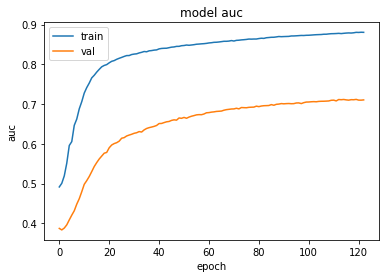

In [65]:
simple_keras_model.fit([X_train,train_embs_bert], Y_train, 
            validation_data=([X_val,val_embs_bert], Y_val),
            batch_size=16,
            epochs=500,
            verbose=True,
            callbacks=[early_stop])
plt.plot(simple_keras_model.history.history['auc'])
plt.plot(simple_keras_model.history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()